In [4]:

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

**Importacion de datos procesados**

Importamos los datos procesados en el analisis EDA

In [5]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


**Creación de funciones generales**

Crearemos funciones generales que seran usadas en cada variante que se crearan, esto con el fin de evitar escribir codigo en cada variante

In [6]:
def seleccionar_orden_var(data, maxlags=4):
    modelo = VAR(data)
    resultados = modelo.select_order(maxlags=maxlags)   
    # Obtener el orden recomendado por AIC
    orden_aic = resultados.aic
    print(f"\nOrden recomendado por AIC: {orden_aic}")
    
    return orden_aic

In [7]:
def entrenar_var(data, orden):
    modelo = VAR(data)
    modelo_fit = modelo.fit(orden)

    # Predicciones en el mismo rango de entrenamiento
    y_train_pred = modelo_fit.fittedvalues
    mae_train = {}
    rmse_train = {}

    for col in y_train_pred.columns:
        mae_train[col] = mean_absolute_error(data[col][ modelo_fit.k_ar:], y_train_pred[col])
        rmse_train[col] = np.sqrt(mean_squared_error(data[col][modelo_fit.k_ar:], y_train_pred[col]))

    print("MAE entrenamiento:", mae_train)
    print("RMSE entrenamiento:", rmse_train)
    
    return modelo_fit

In [8]:
def predecir_var(modelo_fit, steps, data_train):
    # Obtener los últimos valores para inicializar las predicciones
    lag_order = modelo_fit.k_ar
    forecast_input = data_train.values[-lag_order:]
    
    # Realizar predicción
    forecast = modelo_fit.forecast(forecast_input, steps)
    
    # Convertir a DataFrame con las mismas columnas
    forecast_df = pd.DataFrame(forecast, columns=data_train.columns)
    
    return forecast_df

In [24]:
def evaluar_modelo_var(y_real, y_pred):
    resultados = {}
    
    for columna in y_real.columns:
        mae = mean_absolute_error(y_real[columna], y_pred[columna])
        mse = mean_squared_error(y_real[columna], y_pred[columna])
        rmse = np.sqrt(mse)
        
        resultados[columna] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
    
    return resultados



In [10]:
def diagnosticos_var(modelo_fit):
    print("\n=== DIAGNÓSTICOS DEL MODELO VAR ===")
    
    # Test de autocorrelación serial (Breusch-Godfrey)
    try:
        test_serial = modelo_fit.test_serial_correlation(lags=10)
        print(f"Test de Autocorrelación Serial (p-value): {test_serial.pvalue:.6f}")
        
        if test_serial.pvalue > 0.05:
            print("No hay evidencia de autocorrelación serial")
        else:
            print("Existe autocorrelación serial en los residuos")
    except:
        print("No se pudo realizar el test de autocorrelación serial")
    
    # Test de normalidad de residuos
    try:
        test_normalidad = modelo_fit.test_normality()
        print(f"Test de Normalidad (p-value): {test_normalidad.pvalue:.6f}")
        
        if test_normalidad.pvalue > 0.05:
            print("Los residuos siguen distribución normal")
        else:
            print("Los residuos NO siguen distribución normal")
    except:
        print("No se pudo realizar el test de normalidad")
    
    print("EVALUACION GENERAL DEL MODELO VAR:")
    print(f"AIC: {modelo_fit.aic:.6f}")
    print(f"BIC: {modelo_fit.bic:.6f}")
    print(f"Log-Likelihood: {modelo_fit.llf:.6f}")
    
    return {
        'AIC': modelo_fit.aic,
        'BIC': modelo_fit.bic,
        'Log_Likelihood': modelo_fit.llf
    }

In [11]:
def test_causalidad_granger(modelo_fit, variable_objetivo='pib'):
    #Realiza test de causalidad de Granger
    print(f"\n=== TEST DE CAUSALIDAD DE GRANGER - {variable_objetivo.upper()} ===")
    
    # Test de causalidad para cada variable hacia la variable objetivo
    for var in modelo_fit.names:
        if var != variable_objetivo:
            try:
                resultado = modelo_fit.test_causality(variable_objetivo, [var])
                print(f"{var} -> {variable_objetivo}: p-value = {resultado.pvalue:.6f}")
                
                if resultado.pvalue <= 0.05:
                    print(f"  {var} causa Granger a {variable_objetivo}")
                else:
                    print(f"  {var} NO causa Granger a {variable_objetivo}")
            except:
                print(f"  No se pudo realizar test para {var}")

In [12]:
def analisis_impulso_respuesta(modelo_fit, periodos=10):
    print(f"\n=== ANÁLISIS DE IMPULSO-RESPUESTA ({periodos} períodos) ===")
    
    # Calcular impulso-respuesta
    irf = modelo_fit.irf(periodos)
    
    # Mostrar resumen
    print("Funciones de impulso-respuesta calculadas")
    print(f"Variables: {modelo_fit.names}")
    
    return irf

In [13]:
def graficar_resultados_var(y_train, y_test, y_pred, fechas_train, fechas_test, variable_a_graficar, scaler_path='data/scaler_pib.joblib'):
    scaler = joblib.load(scaler_path)

    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test)
    if isinstance(y_pred, np.ndarray):
        pass

    # Desnormalizar todos los datos
    y_train_desnormalizado = scaler.inverse_transform(y_train)
    y_test_desnormalizado = scaler.inverse_transform(y_test)
    y_pred_desnormalizado = scaler.inverse_transform(y_pred) # Aplica el scaler a todas las columnas predichas

    # Convertir a DataFrame para facilitar la selección
    if isinstance(y_train, pd.DataFrame):
        y_train_desnormalizado = pd.DataFrame(y_train_desnormalizado, columns=y_train.columns)
        y_test_desnormalizado = pd.DataFrame(y_test_desnormalizado, columns=y_test.columns)
        y_pred_desnormalizado = pd.DataFrame(y_pred_desnormalizado, columns=y_test.columns)


    # Seleccionar la variable específica para graficar
    if isinstance(variable_a_graficar, str):
        try:
            pib_train = y_train_desnormalizado[variable_a_graficar]
            pib_test = y_test_desnormalizado[variable_a_graficar]
            pib_pred = y_pred_desnormalizado[variable_a_graficar]
        except KeyError:
            print(f"La variable '{variable_a_graficar}' no se encontró en los datos. Por favor, verifica el nombre o usa el índice numérico.")
            return
    elif isinstance(variable_a_graficar, int):
        pib_train = y_train_desnormalizado[:, variable_a_graficar]
        pib_test = y_test_desnormalizado[:, variable_a_graficar]
        pib_pred = y_pred_desnormalizado[:, variable_a_graficar]
    else:
        print("El argumento 'variable_a_graficar' debe ser un string (nombre de columna) o un entero (índice de columna).")
        return

    # Visualizar
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(fechas_test, pib_test,color='green', marker='.', label=f"Valor real {variable_a_graficar}", linestyle='-')
    plt.plot(fechas_test, pib_pred,color='blue', marker='.', label=f"Predicción {variable_a_graficar}",linestyle=':')
    plt.plot(fechas_train, pib_train, color='green', marker='.', label=f"Histórico (Valor real) {variable_a_graficar}",linestyle='--')
    plt.ylabel(f'{variable_a_graficar} de Bolivia')
    plt.xlabel('Fecha')
    plt.title("Predción del Modelo VAR")
    plt.legend()
    
    # Quitar las líneas de contorno y fondo (spines)
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().patch.set_facecolor('#F2F2F2')
    plt.gca().set_facecolor('#F2F2F2')
    plt.show()

In [14]:
def graficar_dispersion(y_train, y_test, y_pred, fechas_train, fechas_test, variable_a_graficar, scaler_path='data/scaler_pib.joblib'):
    scaler = joblib.load(scaler_path)

    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test)
    if isinstance(y_pred, np.ndarray):
        pass

    # Desnormalizar todos los datos
    y_train_desnormalizado = scaler.inverse_transform(y_train)
    y_test_desnormalizado = scaler.inverse_transform(y_test)
    y_pred_desnormalizado = scaler.inverse_transform(y_pred) # Aplica el scaler a todas las columnas predichas

    # Convertir a DataFrame para facilitar la selección
    if isinstance(y_train, pd.DataFrame):
        y_train_desnormalizado = pd.DataFrame(y_train_desnormalizado, columns=y_train.columns)
        y_test_desnormalizado = pd.DataFrame(y_test_desnormalizado, columns=y_test.columns)
        y_pred_desnormalizado = pd.DataFrame(y_pred_desnormalizado, columns=y_test.columns)


    # Seleccionar la variable específica para graficar
    if isinstance(variable_a_graficar, str):
        try:
            pib_train = y_train_desnormalizado[variable_a_graficar]
            pib_test = y_test_desnormalizado[variable_a_graficar]
            pib_pred = y_pred_desnormalizado[variable_a_graficar]
        except KeyError:
            print(f"La variable '{variable_a_graficar}' no se encontró en los datos. Por favor, verifica el nombre o usa el índice numérico.")
            return
    elif isinstance(variable_a_graficar, int):
        pib_train = y_train_desnormalizado[:, variable_a_graficar]
        pib_test = y_test_desnormalizado[:, variable_a_graficar]
        pib_pred = y_pred_desnormalizado[:, variable_a_graficar]
    else:
        print("El argumento 'variable_a_graficar' debe ser un string (nombre de columna) o un entero (índice de columna).")
        return


    # Visualizar
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_desnormalizado, y_pred_desnormalizado, color='purple', alpha=0.7)
    plt.plot([y_test_desnormalizado.min(), y_test_desnormalizado.max()],
            [y_test_desnormalizado.min(), y_test_desnormalizado.max()],
            'r--', lw=2)
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title("Comparación Valor Real vs Predicción VAR")
    
    # Quitar las líneas de contorno y fondo
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().patch.set_facecolor('#F2F2F2')
    plt.gca().set_facecolor('#F2F2F2')
    plt.show()

In [15]:
def graficar_errores(y_train, y_test, y_pred, fechas_train, fechas_test, variable_a_graficar, scaler_path='data/scaler_pib.joblib'):
    scaler = joblib.load(scaler_path)

    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test)
    if isinstance(y_pred, np.ndarray):
        pass

    # Desnormalizar todos los datos
    y_train_desnormalizado = scaler.inverse_transform(y_train)
    y_test_desnormalizado = scaler.inverse_transform(y_test)
    y_pred_desnormalizado = scaler.inverse_transform(y_pred) # Aplica el scaler a todas las columnas predichas

    # Convertir a DataFrame para facilitar la selección
    if isinstance(y_train, pd.DataFrame):
        y_train_desnormalizado = pd.DataFrame(y_train_desnormalizado, columns=y_train.columns)
        y_test_desnormalizado = pd.DataFrame(y_test_desnormalizado, columns=y_test.columns)
        y_pred_desnormalizado = pd.DataFrame(y_pred_desnormalizado, columns=y_test.columns)


    # Seleccionar la variable específica para graficar
    if isinstance(variable_a_graficar, str):
        try:
            pib_train = y_train_desnormalizado[variable_a_graficar]
            pib_test = y_test_desnormalizado[variable_a_graficar]
            pib_pred = y_pred_desnormalizado[variable_a_graficar]
        except KeyError:
            print(f"La variable '{variable_a_graficar}' no se encontró en los datos. Por favor, verifica el nombre o usa el índice numérico.")
            return
    elif isinstance(variable_a_graficar, int):
        pib_train = y_train_desnormalizado[:, variable_a_graficar]
        pib_test = y_test_desnormalizado[:, variable_a_graficar]
        pib_pred = y_pred_desnormalizado[:, variable_a_graficar]
    else:
        print("El argumento 'variable_a_graficar' debe ser un string (nombre de columna) o un entero (índice de columna).")
        return
    
    # Visualizar
    plt.figure(figsize=(10,5))
    plt.plot(fechas_test, pib_test, color='blue', label='Valor real')
    plt.plot(fechas_test,pib_pred, color='red', label='Predicción')
    plt.fill_between(
        fechas_test,
        pib_test.values.flatten(),
        pib_pred.values.flatten(),
        color='orange', alpha=0.3, label='Error'
    )
    plt.legend()
    plt.title("Predicción y Error del Modelo VAR")
    plt.xlabel("Fecha")
    plt.ylabel("PIB")
    
    # Quitar las líneas de contorno y fondo
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().patch.set_facecolor('#F2F2F2')
    plt.gca().set_facecolor('#F2F2F2')
    plt.show()

In [26]:
def generarModelo(df):
    
    #=== MODELO VAR COMPLETO ====#
    # 2008 - 2022 para entrenamiento, 2023 - 2024 para prueba
    data_train = df[df.index < '2023-01-01']
    data_test = df[df.index >= '2023-01-01']
    
    print(f"\nDatos de entrenamiento: {data_train.shape}")
    print(f"Datos de prueba: {data_test.shape}")
    
    print("\n" + "="*50)
    print("SELECCIÓN DE ORDEN ÓPTIMO")
    print("="*50)
    
    orden_optimo = seleccionar_orden_var(data_train)
    
    print("\n" + "="*50)
    print("ENTRENAMIENTO DEL MODELO VAR")
    print("="*50)
    
    modelo_var = entrenar_var(data_train, orden_optimo)
    print(f"Modelo VAR({orden_optimo}) entrenado exitosamente")
    
    print("\n=== RESUMEN DEL MODELO ===")
    print(modelo_var.summary())
    
    # ===============================================
    # 3. PREDICCIONES Y EVALUACIÓN DEL ENTRENAMIENTO
    # ===============================================
    print("\n" + "="*50)
    print("EVALUACIÓN DE ENTRENAMIENTO (In-Sample)")
    print("="*50)
    
    # La predicción de entrenamiento se hace sobre los mismos datos de entrenamiento
    predicciones_train = modelo_var.fittedvalues
    # Si el modelo tiene un retardo (p), fittedvalues comienza en t=p+1.
    # Por simplicidad, alinearemos el data_train real con esta predicción.
    y_real_train = data_train.iloc[orden_optimo:]

    # Calcular métricas de entrenamiento
    metricas_train = evaluar_modelo_var(y_real_train, predicciones_train)

    print("=== MÉTRICAS DE EVALUACIÓN (Entrenamiento) ===")
    for variable, metricas_var in metricas_train.items():
        print(f"\n--- {variable.upper()} ---")
        for metrica, valor in metricas_var.items():
            print(f"{metrica}: {valor:.6f}")
    # ===============================================
    # 4. PREDICCIONES Y EVALUACIÓN DE PRUEBA (TEST)
    # ===============================================
    print("\n" + "="*50)
    print("EVALUACIÓN DE PRUEBA/TEST (Out-of-Sample)")
    print("="*50)

    # Predicciones sobre el conjunto de prueba
    predicciones_test = predecir_var(modelo_var, len(data_test), data_train)
    print(f"Predicciones realizadas: {predicciones_test.shape}")

    # Calcular métricas de prueba
    metricas_test = evaluar_modelo_var(data_test, predicciones_test)

    print("=== MÉTRICAS DE EVALUACIÓN (Prueba/Test) ===")
    for variable, metricas_var in metricas_test.items():
        print(f"\n--- {variable.upper()} ---")
        for metrica, valor in metricas_var.items():
            print(f"{metrica}: {valor:.6f}")
    
    diagnosticos = diagnosticos_var(modelo_var)
    
    if 'pib' in df.columns:
        test_causalidad_granger(modelo_var, 'pib')
    
    irf = analisis_impulso_respuesta(modelo_var)
    graficar_resultados_var(data_train, data_test, predicciones_test, data_train.index, data_test.index,'pib')
    graficar_dispersion(data_train, data_test, predicciones_test, data_train.index, data_test.index,'pib')
    graficar_errores(data_train, data_test, predicciones_test, data_train.index, data_test.index,'pib')
    
    return modelo_var, predicciones_test, metricas_test, irf

**Generación de modelos**

En esta sección generaremos los modelos, cada uno variando en sus variables exogenas para ver el comportamiento y poder elegir el mejor modelo

**Modelo: M1**

En este modelo usaremos las variables: 
- exportaciones
- importaciones 
- precio del petroleo 
- consumo final 
- inversion total 
- tasa de inflacion


Datos de entrenamiento: (57, 7)
Datos de prueba: (8, 7)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'exportaciones': 0.43901677773794734, 'importaciones': 0.194933636561901, 'precio_petroleo': 0.42835326689305664, 'pib': 0.2517217231210867, 'consumo_final': 0.12383280601816825, 'inversion_total': 0.06286138809927995, 'tasa_inflacion': 0.16149666663142448}
RMSE entrenamiento: {'exportaciones': 0.6107420406963323, 'importaciones': 0.25308852171758023, 'precio_petroleo': 0.5627202293003448, 'pib': 0.36403850181364056, 'consumo_final': 0.17857191017412263, 'inversion_total': 0.08184971935796433, 'tasa_inflacion': 0.2044598527354903}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     20:37:59
-----------------------------------------------------------

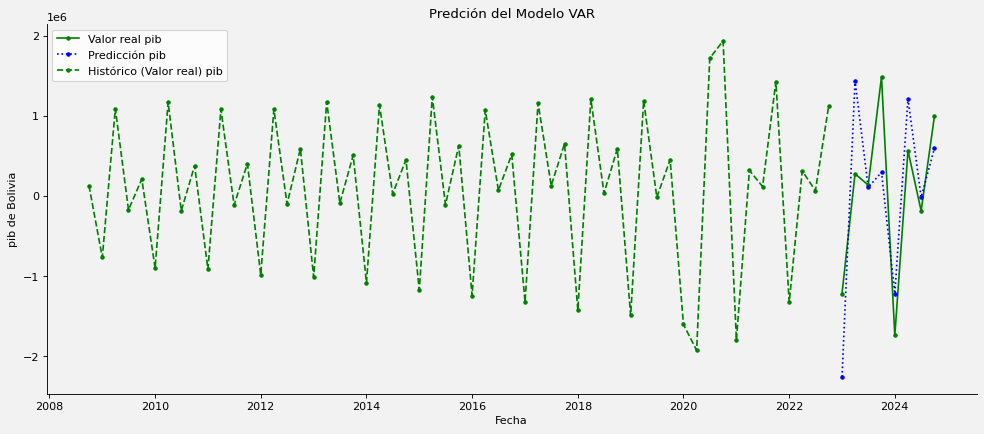

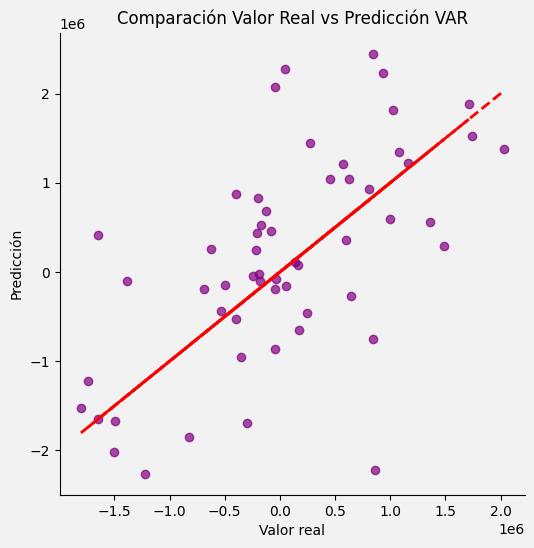

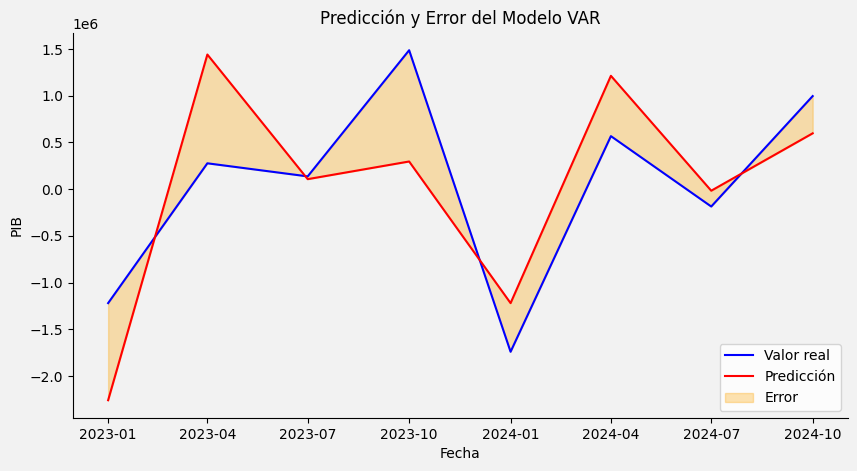

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x2c5014ef730>,
    exportaciones  importaciones  precio_petroleo       pib  consumo_final  \
 0       0.176532      -0.548947         0.811662 -2.429348      -2.179881   
 1       2.431963       2.209661         2.048038  1.394332       0.358456   
 2       0.610598      -0.371734        -2.382950  0.015831      -0.013244   
 3      -2.003588      -0.987256        -0.200488  0.211262       1.326026   
 4       0.331225      -0.197536         2.258279 -1.355419      -1.663104   
 5       1.855611       1.776042         0.978980  1.158860       0.381357   
 6       0.158455      -0.867039        -1.836608 -0.112050      -0.173071   
 7      -1.080005      -0.240660        -0.141529  0.522800       1.484609   
 
    inversion_total  tasa_inflacion  
 0        -1.819606       -0.290428  
 1         1.289275        0.480793  
 2        -0.293222       -0.638141  
 3         0.865826        0.765273  
 4        -1.799811       -0.76

In [27]:
df1 = df.drop('igae', axis=1)
generarModelo(df1)

**Modelo: M2**

En este modelo usaremos las variables: 
- exportaciones
- precio del petroleo 
- inversion total 
- tasa de inflacion


Datos de entrenamiento: (57, 5)
Datos de prueba: (8, 5)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'exportaciones': 0.47693950262714563, 'precio_petroleo': 0.5439527811503327, 'pib': 0.2586094566597609, 'inversion_total': 0.1008876345235236, 'tasa_inflacion': 0.19812280442044422}
RMSE entrenamiento: {'exportaciones': 0.6784556996749745, 'precio_petroleo': 0.7026601448030526, 'pib': 0.43939846943202887, 'inversion_total': 0.13531152818650863, 'tasa_inflacion': 0.2534289480027281}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     20:38:09
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -3.96903
Nobs:                     53.0000    HQIC:                  -6.37137
Log 

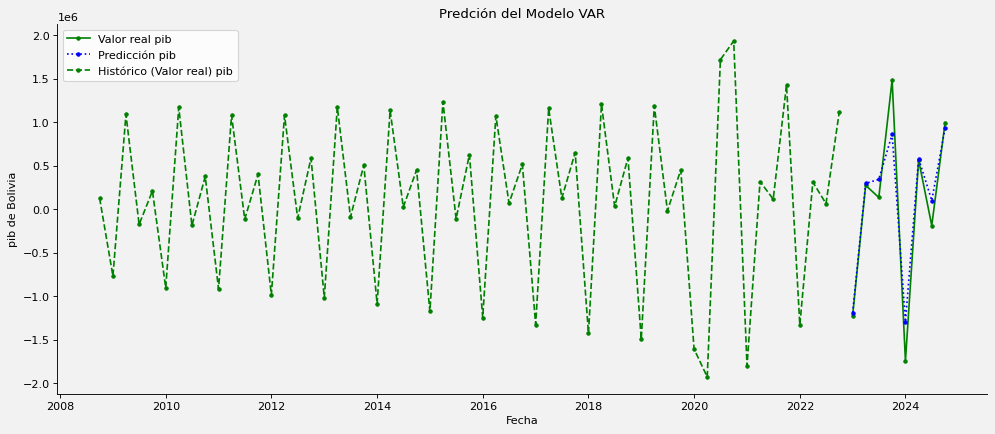

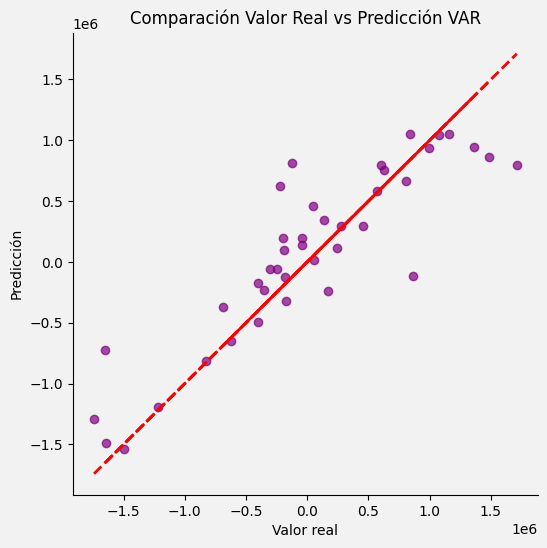

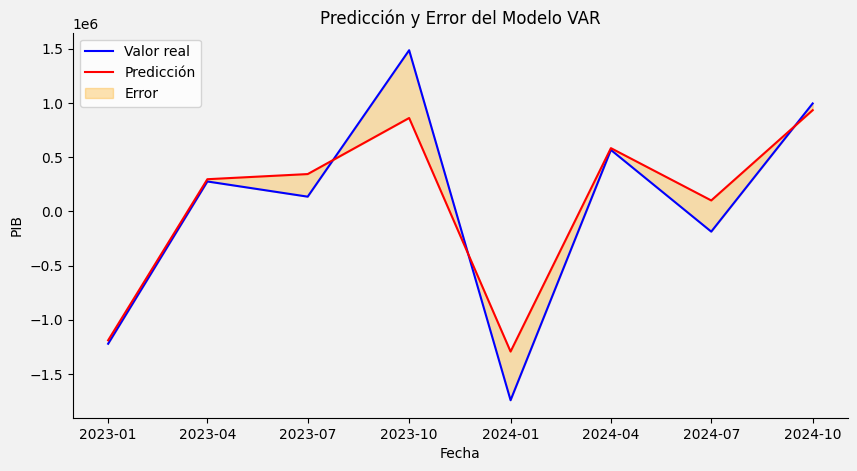

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x2c501481690>,
    exportaciones  precio_petroleo       pib  inversion_total  tasa_inflacion
 0      -0.764431        -0.276499 -1.322623        -1.682554       -0.476463
 1       0.989993         0.111067  0.212665         0.983884        0.880057
 2       0.748381        -0.216657  0.261726         0.047248       -0.603123
 3      -0.937559        -0.220529  0.796046         0.596547        0.110695
 4      -0.840307         0.381073 -1.429801        -1.632572       -0.341994
 5       0.727320         0.210337  0.508788         0.994658        0.726332
 6       0.546735        -0.155951  0.010362        -0.079605       -0.428739
 7      -0.333115        -0.156217  0.870690         0.686916        0.020977,
 {'exportaciones': {'MAE': 0.5159338651945982,
   'MSE': 0.447463460482843,
   'RMSE': 0.6689270965380629},
  'precio_petroleo': {'MAE': 0.3237441407227453,
   'MSE': 0.18176382587664225,
   'RMSE': 0.4263376899555589},
  

In [28]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
generarModelo(df2)

**Modelo: M3**

En este modelo usaremos las variables: 
- importaciones 
- precio del petroleo 
- consumo final 
- tasa de inflacion


Datos de entrenamiento: (57, 5)
Datos de prueba: (8, 5)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'importaciones': 0.24932077781176967, 'precio_petroleo': 0.4747239865707488, 'pib': 0.23934015901353387, 'consumo_final': 0.12380933162002325, 'tasa_inflacion': 0.20102898846894704}
RMSE entrenamiento: {'importaciones': 0.3284248142542772, 'precio_petroleo': 0.6142951252973775, 'pib': 0.4185299007054909, 'consumo_final': 0.21280392350831787, 'tasa_inflacion': 0.25622604950174555}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     20:38:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -7.45034
Nobs:                     53.0000    HQIC:                  -9.85269
Log li

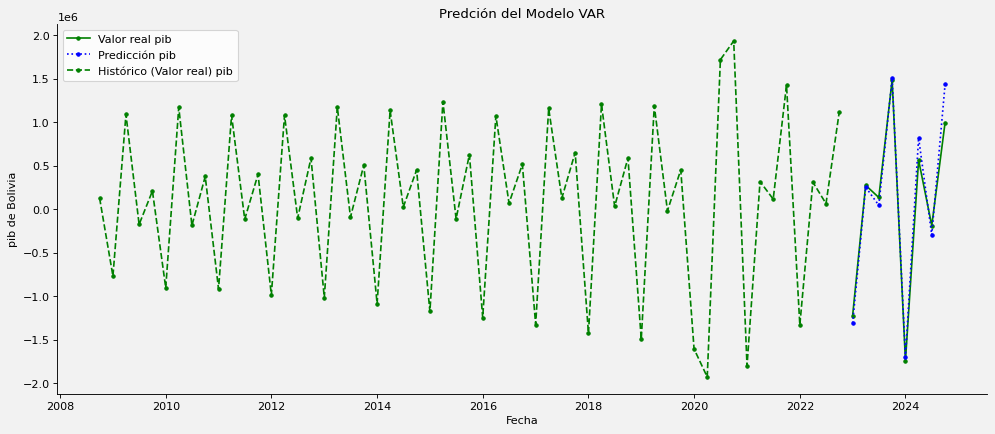

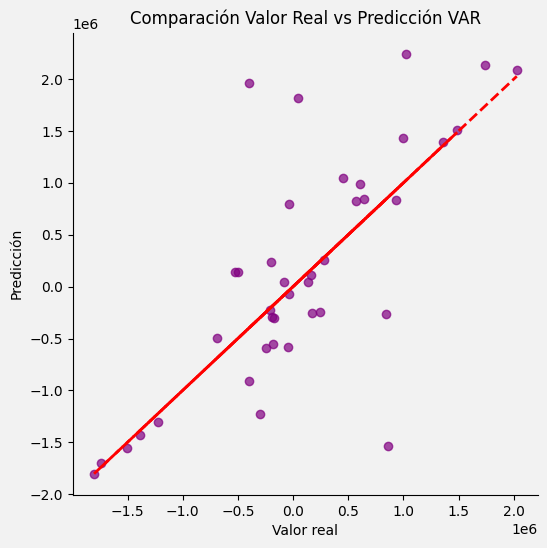

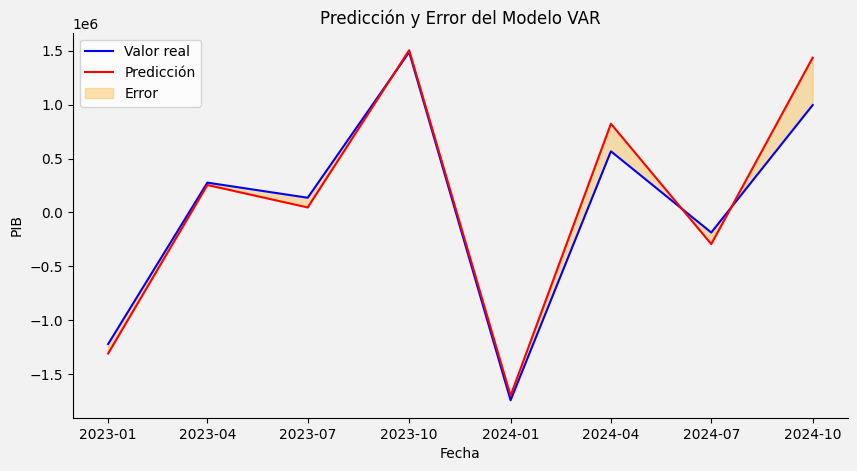

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x2c5014c4fd0>,
    importaciones  precio_petroleo       pib  consumo_final  tasa_inflacion
 0       0.050215         1.935109 -1.445759      -1.696446       -0.606617
 1       0.768987         0.731783  0.168579      -0.322837        1.344513
 2       0.777434        -1.679591 -0.046606       0.017153       -1.031542
 3      -0.693225        -0.668561  1.459787       2.061456        0.148782
 4      -1.574086         1.786383 -1.850169      -1.956767       -0.360625
 5       2.224095         0.986604  0.755452      -0.044181        0.932018
 6      -0.363815        -1.359055 -0.397489      -0.168572       -0.405411
 7       0.049711        -0.706509  1.388458       2.112844       -0.343360,
 {'importaciones': {'MAE': 0.5814982965628516,
   'MSE': 0.521038252342646,
   'RMSE': 0.7218297945794743},
  'precio_petroleo': {'MAE': 1.2411600665062374,
   'MSE': 2.2214038838144337,
   'RMSE': 1.49043748067956},
  'pib': {'MAE': 0.1369

In [29]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
generarModelo(df3)

**Modelo: M4**

En este modelo usaremos las variables:
- precio del petroleo 
- consumo final 
- tasa de inflacion


Datos de entrenamiento: (57, 4)
Datos de prueba: (8, 4)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'precio_petroleo': 0.566129086055315, 'pib': 0.23616557886290968, 'consumo_final': 0.12483460675073825, 'tasa_inflacion': 0.20165963496735922}
RMSE entrenamiento: {'precio_petroleo': 0.7210578755991006, 'pib': 0.4310095322823823, 'consumo_final': 0.22078696081546795, 'tasa_inflacion': 0.2724854044619374}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     20:38:24
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -6.74809
Nobs:                     53.0000    HQIC:                  -8.30390
Log likelihood:           12.9994    FPE:                0.000102859
AIC:          

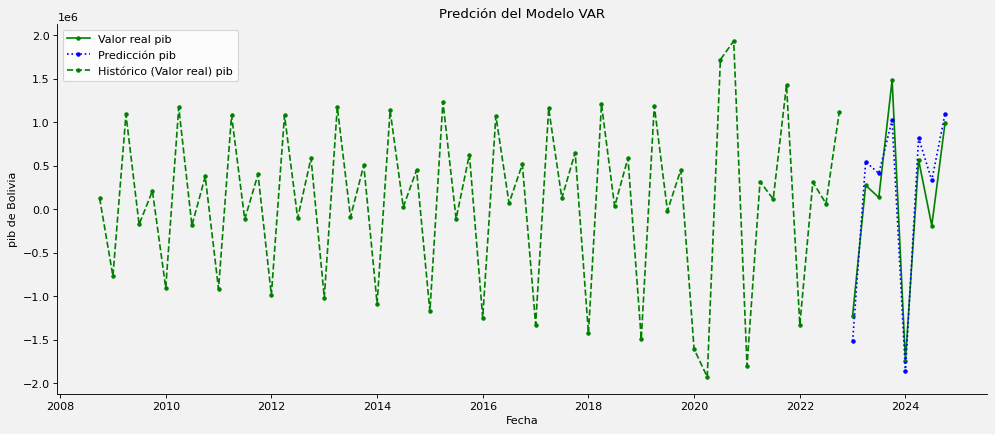

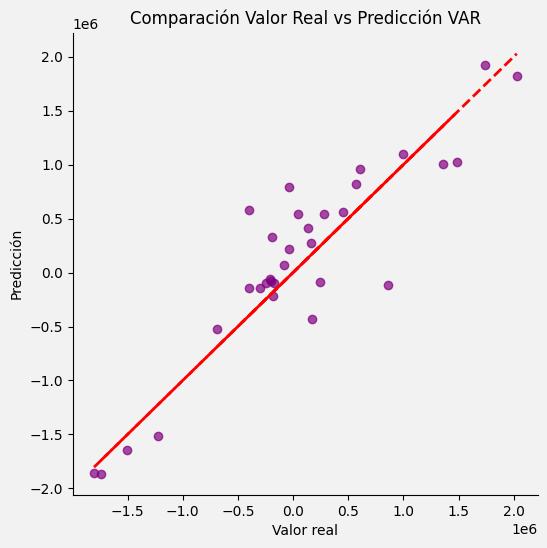

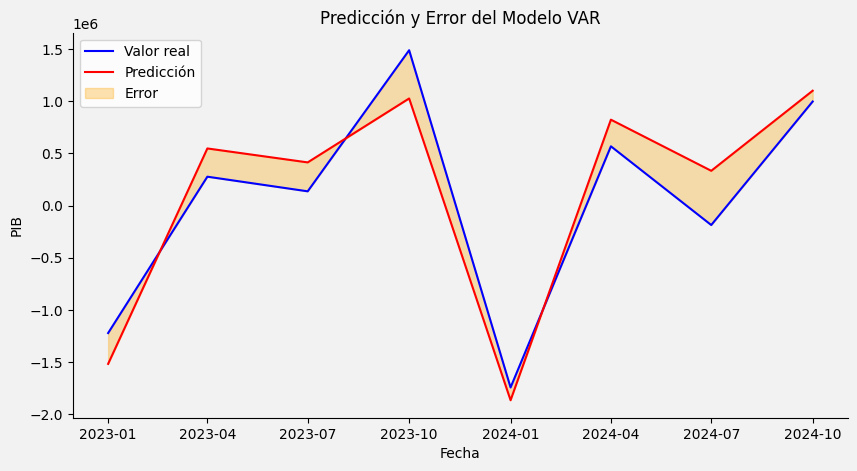

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x2c501482f80>,
    precio_petroleo       pib  consumo_final  tasa_inflacion
 0         0.504652 -1.660253      -1.794089       -0.639163
 1         0.722213  0.470420      -0.158240        0.943990
 2        -0.215526  0.332429       0.183914       -0.242312
 3        -0.317178  0.964838       1.789612       -0.178641
 4         0.469612 -2.019630      -2.009972       -0.534339
 5         0.481565  0.755041      -0.017563        0.896342
 6        -0.239829  0.249317       0.134550       -0.189716
 7        -0.195544  1.041463       1.887811       -0.188857,
 {'precio_petroleo': {'MAE': 0.48222330178851447,
   'MSE': 0.38934980562626204,
   'RMSE': 0.6239790105654693},
  'pib': {'MAE': 0.2974707283801159,
   'MSE': 0.10807016616603923,
   'RMSE': 0.3287402715914788},
  'consumo_final': {'MAE': 0.1590382613814239,
   'MSE': 0.02894623830508306,
   'RMSE': 0.1701359406624099},
  'tasa_inflacion': {'MAE': 0.292170710858146,
   'M

In [30]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
generarModelo(df4)

**Modelo: M5**

En este modelo usaremos las variables: 
- importaciones 
- precio del petroleo 
- tasa de inflacion


Datos de entrenamiento: (57, 4)
Datos de prueba: (8, 4)

SELECCIÓN DE ORDEN ÓPTIMO

Orden recomendado por AIC: 4

ENTRENAMIENTO DEL MODELO VAR
MAE entrenamiento: {'importaciones': 0.2953484701626629, 'precio_petroleo': 0.5373524987572658, 'pib': 0.2597406234575533, 'tasa_inflacion': 0.19216636541049373}
RMSE entrenamiento: {'importaciones': 0.3864741171460412, 'precio_petroleo': 0.6726972087947498, 'pib': 0.4802314328999095, 'tasa_inflacion': 0.2735368225510378}
Modelo VAR(4) entrenado exitosamente

=== RESUMEN DEL MODELO ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     20:38:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -2.20806
Nobs:                     53.0000    HQIC:                  -3.76386
Log likelihood:          -107.312    FPE:                 0.00963732
AIC:            

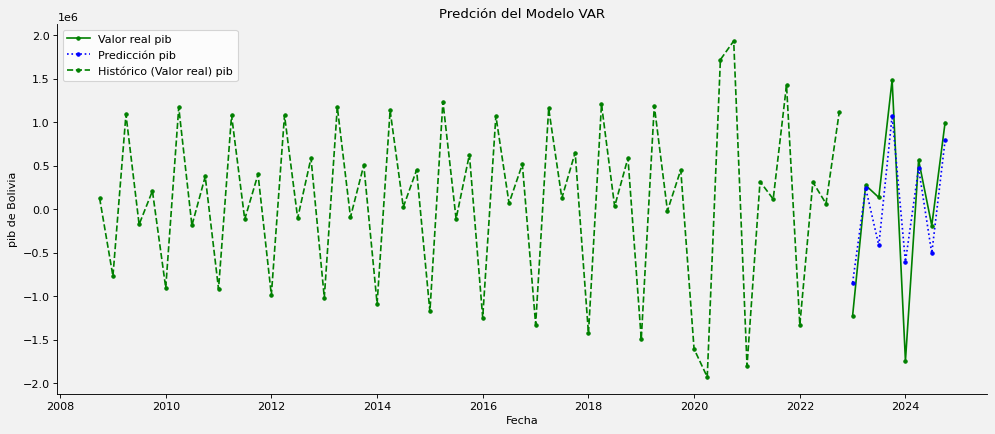

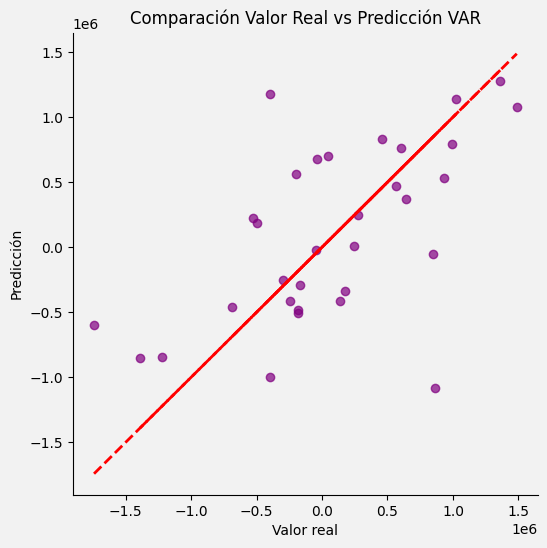

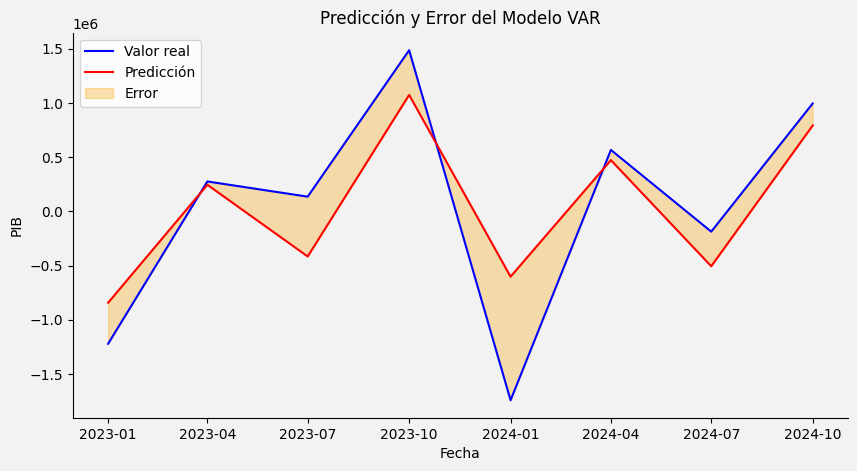

(<statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x2c502eb2680>,
    importaciones  precio_petroleo       pib  tasa_inflacion
 0       0.141073         1.124124 -0.964516       -0.567967
 1       0.451877         0.606544  0.159621        1.222487
 2       0.291174        -1.216043 -0.523461       -1.123952
 3      -0.117822        -0.597229  1.015993        0.484746
 4      -0.972705         0.627537 -0.716045       -0.441694
 5       1.084660         0.763914  0.394278        0.692559
 6      -0.148251        -0.358000 -0.616619       -0.390801
 7       0.093751        -0.521789  0.724481       -0.082249,
 {'importaciones': {'MAE': 0.4766558101648136,
   'MSE': 0.3175100189812665,
   'RMSE': 0.5634802738173418},
  'precio_petroleo': {'MAE': 0.7483704200866185,
   'MSE': 0.9997296180723283,
   'RMSE': 0.9998647998966301},
  'pib': {'MAE': 0.40411666813029257,
   'MSE': 0.27607834063866593,
   'RMSE': 0.5254315756011109},
  'tasa_inflacion': {'MAE': 0.3471406587215067,
   'MS

In [31]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
generarModelo(df5)

**Conclusión**

En base a los valores obtenidos en cada modelo generado, se puede apreciar y seleccionar al modelo **M3** como el mejor modelo de todos